<a href="https://colab.research.google.com/github/nonu0/Facial-recognition/blob/master/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd 
import random
from pathlib import Path
import cv2
import numpy as np
from torch.utils.data import DataLoader
from sklearn.datasets import make_circles
from torchvision import datasets,transforms
import os
from typing import List,Tuple,Dict
from torch import nn
from google.colab import drive
import torch.utils.data as data
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download vishesh1412/celebrity-face-image-dataset


 85% 45.0M/52.9M [00:03<00:00, 19.7MB/s]
100% 52.9M/52.9M [00:03<00:00, 16.9MB/s]


In [ ]:
! unzip celebrity-face-image-dataset.zip

In [ ]:
data_dir = Path('/content/Celebrity Faces Dataset')
data_dir

PosixPath('/content/Celebrity Faces Dataset')

In [ ]:
all_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
])

In [ ]:
datafolder = datasets.ImageFolder(root=data_dir,transform=all_transform)
datafolder

Dataset ImageFolder
    Number of datapoints: 1800
    Root location: /content/Celebrity Faces Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
class_names = datafolder.classes
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x)
               for x in os.listdir(os.path.join(data_dir, class_name))]
               for class_name in class_names]
image_files

In [ ]:
image_list = list(data_dir.glob('*/*.jpg'))
random_image = random.choice(image_list)
print(f"class name:{random_image.parent.stem}")
print(f"image name:{random_image.name}")

class name:Nicole Kidman
image name:027_6ef3705e.jpg


Text(0.5, 1.0, 'Angelina Jolie')

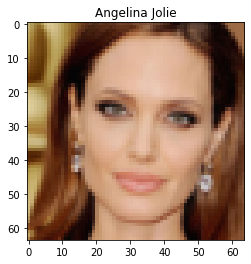

In [ ]:
image,label = datafolder[1]
class_names[label],image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])

In [ ]:
image.shape

torch.Size([3, 64, 64])

In [ ]:
datafolder.class_to_idx

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Denzel Washington': 2,
 'Hugh Jackman': 3,
 'Jennifer Lawrence': 4,
 'Johnny Depp': 5,
 'Kate Winslet': 6,
 'Leonardo DiCaprio': 7,
 'Megan Fox': 8,
 'Natalie Portman': 9,
 'Nicole Kidman': 10,
 'Robert Downey Jr': 11,
 'Sandra Bullock': 12,
 'Scarlett Johansson': 13,
 'Tom Cruise': 14,
 'Tom Hanks': 15,
 'Will Smith': 16}

In [ ]:
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str] = None,
                          n:int = 10,
                          display_shape:bool = True,
                          seed:int = None):
    # adjust display if too high
    if n > 7:
        n = 7
        display_shape = False
        print(f"display is too high")

    # set seed
    if seed:
        random.seed(seed)

    # get random indexes
    random_sample_idx = random.sample(range(len(dataset)),k=n)

    # setup plot
    plt.figure(figsize=(10,7))

    # loop through random indexes and plot them
    for i,targ_sample in enumerate(random_sample_idx):
        targ_image,targ_label = dataset[targ_sample][0],dataset[targ_sample][1]

        # adjust tensor for matplotlib
        targ_image_adjusted = targ_image.permute(1,2,0)

        # plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjusted)
        plt.axis('off')
        if classes:
            title = f"class: {classes[targ_label]}"
            # if display_shape:
                # title = title + f"\nshape:{targ_image_adjusted.shape}"

        plt.title(title)

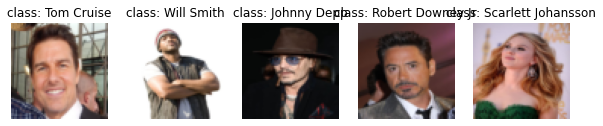

In [ ]:

display_random_images(datafolder,class_names,n=5)

In [ ]:
train_length = int(len(datafolder)*0.8)
test_length = len(datafolder) - train_length
train_data,test_data = data.random_split(datafolder,[train_length,test_length])
len(train_data),len(test_data)

(1440, 360)

Text(0.5, 1.0, 'Natalie Portman')

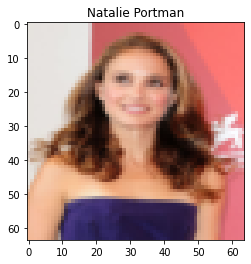

In [ ]:
image,label = test_data[0]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])

In [ ]:
train_dataloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=32,shuffle=False)
len(train_dataloader),len(test_dataloader)


(45, 12)

In [ ]:
image_from_loader,label_from_loader = next(iter(train_dataloader))
image_from_loader.shape,len(label_from_loader)

(torch.Size([32, 3, 64, 64]), 32)

In [ ]:
class FaceClassifierModel(nn.Module):
    def __init__(self,input_feature,hidden_layers,output_features):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_feature,out_channels=hidden_layers,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,out_channels=hidden_layers,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers,out_channels=hidden_layers,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,out_channels=hidden_layers,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*5*5,out_features=output_features)
        )

    def forward(self,x):
        x = self.layer1(x)
        print(f'layer1:{x.shape}')
        x = self.layer2(x)
        print(f'layer2:{x.shape}')
        x = self.classifier(x)
        print(f'classifier:{x.shape}')

In [ ]:
model = FaceClassifierModel(input_feature=3,hidden_layers=10,output_features=len(class_names))
model

FaceClassifierModel(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=250, out_features=17, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)

In [ ]:
def train_loop(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn,optimizer):
    # train loop
    model.train()
    train_loss,train_accuracy = 0,0
    # train the model
    for batch,(X,y) in enumerate(train_dataloader):
        train_predictions = model(X)
        # get the loss
        loss = loss_fn(train_predictions,y)
        train_loss += loss
        # train_pred_labels = torch.argmax(torch.softmax(train_pred_labels == y,dim=1),dim=1)
        # train_accuracy += (train_pred_labels == y).sum().item()/len(train_pred_labels)
        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)

    return train_loss,train_accuracy

def test_loop(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn,optimizer):
    # test loop
    model.eval()
    test_loss,test_accuracy = 0,0
    with torch.inference_mode():
        # test model
        for batch,(X,y) in enumerate(test_dataloader):
            test_predictions = model(X)
            # get loss
            test_loss += loss_fn(test_predictions,y)

            test_pred_labels = torch.argmax(torch.softmax(test_predictions,dim=1),dim=1)
            test_accuracy += (test_pred_labels == y).sum().item()/len(test_pred_labels)

        test_loss = test_loss/len(dataloader)
        test_accuracy = test_accuracy/len(dataloader)

        return test_loss,test_accuracy

In [ ]:
from tqdm import tqdm
Epochs = 10

results = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}
def train(model:torch.nn.Module,train_dataloader:torch.utils.data.DataLoader,test_dataloader:torch.utils.data.DataLoader,loss_fn,optimizer):
    for epoch in tqdm(range(Epochs)):
        train_loss,train_accuracy = train_loop(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer)
        test_loss,test_accuracy = test_loop(model=model,dataloader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer)

        print(f"Epoch:{epoch} | train loss: {train_loss} | train accuracy: {train_accuracy} | test loss:{test_loss} | test accuracy:{test_accuracy}")

        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
    return results


In [ ]:
model_results = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer)
model_results

  0%|          | 0/10 [00:00<?, ?it/s]

layer1:torch.Size([32, 10, 20, 20])
layer2:torch.Size([32, 10, 5, 5])
classifier:torch.Size([32, 17])


TypeError: ignored